<table class="table table-bordered">
    <tr>
        <th style="text-align:center; width:25%"><img src='https://www.np.edu.sg/PublishingImages/Pages/default/odp/ICT.jpg' style="width: 250px; height: 125px; "></th>
        <th style="text-align:center;"><h1>Deep Learning</h1><h2>Assignment 2  (Problem 2) - Character Generator Model (Individual)</h2><h3>AY2021/22 Semester</h3></th>
    </tr>
</table>

In [1]:
# Import the Required Packages
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout
from tensorflow.keras import optimizers
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import matplotlib.pyplot as plt
from tensorflow.keras import models
import random
import sys

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


## Step 1 – Data Loading and Processing

### 1.1 Data Loading

In [2]:
# load text into memory
def load_text(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    text = text.lower()
    return text

filepath = 'D://NPY2SEM1//DL//Asg2//holmes.txt'
text = load_text(filepath)
print("The total number of characters in the original text is " + str(len(text)) + " characters.")

The total number of characters in the original text is 562439 characters.


### 1.2 Data Processing


In [3]:
# Creating a list of unique characters for uncleansed text
unique_chars = sorted(list(set(text)))
print(unique_chars)
# As there are many undesirable characters in the unique characters we printed out, we would like to remove them
# Hence the need for basic data cleansing to remove unnecessary Characters.

['\n', ' ', '!', '"', '&', "'", '(', ')', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\xa0', '¢', '¨', '©', '»', '¿', 'ã', 'ï']


In [4]:
# Basic data cleansing to remove unnecessary characters 
text = text.replace("\n", " " ) #This was done to prevent words in different lines to stick together.
unnecessary_characters = ['"', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '\xa0', '¢', '¨', '©', '»', '¿', 'ã', 'ï']
# Removed " too as it affected the words
clean_text = ''.join(i for i in text if not i in unnecessary_characters)
print(unnecessary_characters)
print(clean_text)
# This removed all the unnecessary characters like ã
# However, certain characters like ' ', and punctuations have to be kept

['"', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '\xa0', '¢', '¨', '©', '»', '¿', 'ã', 'ï']
the adventures of sherlock holmes by sir arthur conan doyle     i. a scandal in bohemia   ii. the red-headed league  iii. a case of identity   iv. the boscombe valley mystery    v. the five orange pips   vi. the man with the twisted lip  vii. the adventure of the blue carbuncle viii. the adventure of the speckled band   ix. the adventure of the engineer's thumb    x. the adventure of the noble bachelor   xi. the adventure of the beryl coronet  xii. the adventure of the copper beeches   adventure i. a scandal in bohemia  i.  to sherlock holmes she is always the woman. i have seldom heard him mention her under any other name. in his eyes she eclipses and predominates the whole of her sex. it was not that he felt any emotion akin to love for irene adler. all emotions, and that one particularly, were abhorrent to his cold, precise but admirably balanced mind. he was, i take it, the most perfe

In [5]:
# Identifying a list of unique characters and punctuations in the clean text.
clean_unique_chars = sorted(list(set(clean_text)))
print(clean_unique_chars)

[' ', '!', '&', "'", '(', ')', ',', '-', '.', '/', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [6]:
# Length of extracted character sequences
maxlen = 60

# We sample a new sequence every `step` characters
step = 3

# This holds our extracted sequences
sentences = []

# This holds the targets (the follow-up characters)
next_chars = []

for i in range(0, len(clean_text) - maxlen, step):
    sentences.append(clean_text[i: i + maxlen])
    next_chars.append(clean_text[i + maxlen])
print('Number of sequences:', len(sentences))

# List of unique characters in the corpus
chars = sorted(list(set(clean_text)))
print('Unique characters:', len(chars))
# Dictionary mapping unique characters to their index in `chars`
char_indices = dict((char, chars.index(char)) for char in chars)



Number of sequences: 185646
Unique characters: 39


In [7]:
# One hot encoding 
# List of unique characters in the corpus
chars = sorted(list(set(clean_text)))
print('Unique characters:', len(chars))
# Dictionary mapping unique characters to their index in `chars`
char_indices = dict((char, chars.index(char)) for char in chars)

# Next, one-hot encode the characters into binary arrays.
print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)

for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1


Unique characters: 39
Vectorization...


In [8]:
print(x.shape)
print(y.shape)

(185646, 60, 39)
(185646, 39)


## Step 2 – Develop Character Generator Model (LSTM Prevent Overfitting)

In [10]:
model = keras.models.Sequential()
model.add(layers.LSTM(128, return_sequences=True,input_shape=(maxlen, len(chars))))
model.add(layers.Dropout(0.3))
model.add(layers.LSTM(128, return_sequences=True))
model.add(layers.LSTM(128))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(len(chars), activation='softmax'))
optimizer = optimizers.RMSprop(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['acc'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 60, 128)           86016     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 60, 128)           131584    
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 39)                5031      
Total params: 354,215
Trainable params: 354,215
Non-trainable params: 0
________________________________________________

In [11]:
history = model.fit(x, y,
                    epochs=20,
                    batch_size=128,
                    validation_split=0.2)


Train on 148516 samples, validate on 37130 samples
Epoch 1/20
148516/148516 [==============================] - 59s 394us/sample - loss: 2.5524 - acc: 0.2719 - val_loss: 2.2110 - val_acc: 0.3492569 - - ETA: 1:14 - ETA:
Epoch 2/20
148516/148516 [==============================] - 43s 287us/sample - loss: 2.0989 - acc: 0.3817 - val_loss: 1.9391 - val_acc: 0.4159
Epoch 3/20
148516/148516 [==============================] - 43s 289us/sample - loss: 1.9392 - acc: 0.4231 - val_loss: 1.8113 - val_acc: 0.4558 - acc: 0
Epoch 4/20
148516/148516 [==============================] - 43s 287us/sample - loss: 1.8377 - acc: 0.4507 - val_loss: 1.7339 - val_acc: 0.4754oss: 1.838
Epoch 5/20
148516/148516 [==============================] - 43s 288us/sample - loss: 1.7650 - acc: 0.4704 - val_loss: 1.6682 - val_acc: 0.4951 1.7686 - a - ETA: 7s - loss:  - ETA: 5s - loss: 1.7680 - ETA: 5s - lo - ETA: 3s - loss: 1.7654 - ac - ETA: 2s - los - ETA: 1s - loss: 1.7653 - acc - ETA: 0s - loss: 1.7654 -
Epoch 6/20
148516

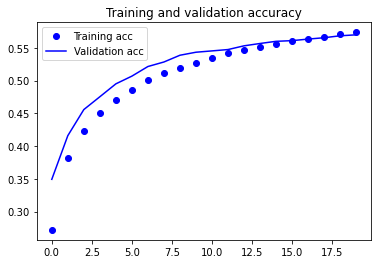

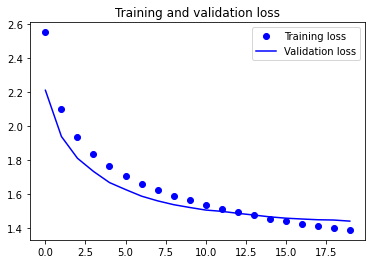

In [12]:
# Plot the Training and Validation Accuracy & Loss Scores
import matplotlib.pyplot as plt

%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Step 2 – Develop Character Generator Model (LSTM Prevent Overfitting with Batch Normalization)

In [13]:
model = keras.models.Sequential()
model.add(layers.LSTM(128, return_sequences=True,input_shape=(maxlen, len(chars))))
model.add(layers.Dropout(0.3))
model.add(layers.LSTM(128, return_sequences=True))
model.add(layers.LSTM(128))
model.add(layers.Dropout(0.3))
model.add(layers.BatchNormalization())
model.add(layers.Dense(len(chars), activation='softmax'))
optimizer = optimizers.RMSprop(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['acc'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 60, 128)           86016     
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 60, 128)           131584    
_________________________________________________________________
lstm_8 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 39)               

In [14]:
history = model.fit(x, y,
                    epochs=20,
                    batch_size=128,
                    validation_split=0.2)


Train on 148516 samples, validate on 37130 samples
Epoch 1/20
148516/148516 [==============================] - 53s 358us/sample - loss: 2.5374 - acc: 0.2811 - val_loss: 2.1857 - val_acc: 0.3599
Epoch 2/20
148516/148516 [==============================] - 47s 314us/sample - loss: 2.1273 - acc: 0.3724 - val_loss: 2.0057 - val_acc: 0.4037
Epoch 3/20
148516/148516 [==============================] - 46s 312us/sample - loss: 1.9780 - acc: 0.4125 - val_loss: 1.8454 - val_acc: 0.4434
Epoch 4/20
148516/148516 [==============================] - 46s 307us/sample - loss: 1.8678 - acc: 0.4441 - val_loss: 1.7452 - val_acc: 0.4734
Epoch 5/20
148516/148516 [==============================] - 46s 307us/sample - loss: 1.7811 - acc: 0.4666 - val_loss: 1.6708 - val_acc: 0.4939A: 12s - loss: 1.787 - ETA: 5s - loss: 1.7826  - ETA: 2s - l - ETA: 0s - loss: 1.7811 - acc: 0.46 - ETA: 0s - loss: 1.7811 - acc: 0.46
Epoch 6/20
148516/148516 [==============================] - 46s 309us/sample - loss: 1.7076 - acc: 0

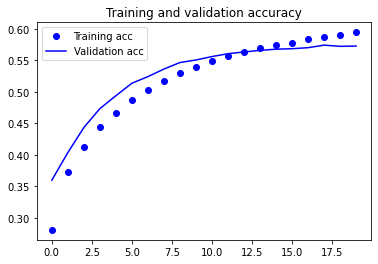

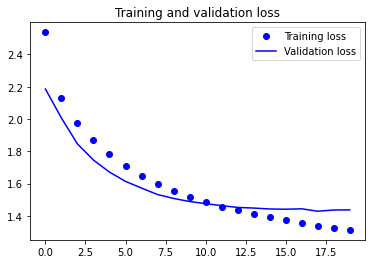

In [15]:
# Plot the Training and Validation Accuracy & Loss Scores
import matplotlib.pyplot as plt

%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Step 2 – Develop Character Generator Model (LSTM Prevent Overfitting with Layer Normalization)

In [16]:
model = keras.models.Sequential()
model.add(layers.LSTM(128, return_sequences=True,input_shape=(maxlen, len(chars))))
model.add(layers.Dropout(0.3))
model.add(layers.LSTM(128, return_sequences=True))
model.add(layers.LSTM(128))
model.add(layers.Dropout(0.3))
model.add(layers.LayerNormalization())
model.add(layers.Dense(len(chars), activation='softmax'))
optimizer = optimizers.RMSprop(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['acc'])
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 60, 128)           86016     
_________________________________________________________________
dropout_6 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 60, 128)           131584    
_________________________________________________________________
lstm_11 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
layer_normalization (LayerNo (None, 128)               256       
_________________________________________________________________
dense_3 (Dense)              (None, 39)               

In [17]:
history = model.fit(x, y,
                    epochs=20,
                    batch_size=128,
                    validation_split=0.2)


Train on 148516 samples, validate on 37130 samples
Epoch 1/20
148516/148516 [==============================] - 53s 357us/sample - loss: 2.5313 - acc: 0.2780 - val_loss: 2.1781 - val_acc: 0.3405 ETA: 5 - ETA: 3s - - ETA: 0s - loss: 2.5374 - acc:  - ETA: 0s - loss: 2.5335 - acc: 0.
Epoch 2/20
148516/148516 [==============================] - 44s 300us/sample - loss: 2.1103 - acc: 0.3769 - val_loss: 1.9793 - val_acc: 0.4052
Epoch 3/20
148516/148516 [==============================] - 45s 305us/sample - loss: 1.9615 - acc: 0.4193 - val_loss: 1.8284 - val_acc: 0.4529
Epoch 4/20
148516/148516 [==============================] - 46s 307us/sample - loss: 1.8492 - acc: 0.4494 - val_loss: 1.7563 - val_acc: 0.4689
Epoch 5/20
148516/148516 [==============================] - 45s 300us/sample - loss: 1.7661 - acc: 0.4715 - val_loss: 1.6921 - val_acc: 0.4947
Epoch 6/20
148516/148516 [==============================] - 45s 300us/sample - loss: 1.6945 - acc: 0.4909 - val_loss: 1.6552 - val_acc: 0.5079
Epoc

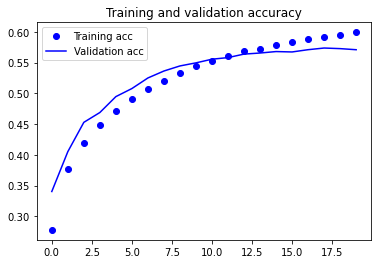

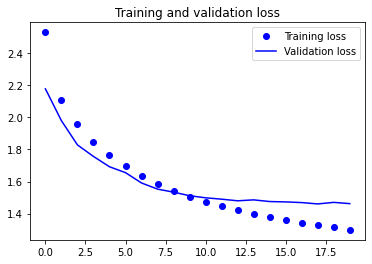

In [18]:
# Plot the Training and Validation Accuracy & Loss Scores
import matplotlib.pyplot as plt

%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Step 2 – Develop Character Generator Model (GRU Prevent Overfitting)

In [35]:
model = keras.models.Sequential()
model.add(layers.GRU(128, return_sequences=True,input_shape=(maxlen, len(chars))))
model.add(layers.Dropout(0.3))
model.add(layers.GRU(128, return_sequences=True))
model.add(layers.GRU(128))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(len(chars), activation='softmax'))
optimizer = optimizers.RMSprop(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['acc'])
model.summary()


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_10 (GRU)                 (None, 60, 128)           64896     
_________________________________________________________________
dropout_16 (Dropout)         (None, 60, 128)           0         
_________________________________________________________________
gru_11 (GRU)                 (None, 60, 128)           99072     
_________________________________________________________________
gru_12 (GRU)                 (None, 128)               99072     
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 39)                5031      
Total params: 268,071
Trainable params: 268,071
Non-trainable params: 0
_______________________________________________

In [36]:
history = model.fit(x, y,
                    epochs=20,
                    batch_size=128,
                    validation_split=0.2)


Train on 148516 samples, validate on 37130 samples
Epoch 1/20
148516/148516 [==============================] - 47s 318us/sample - loss: 2.3128 - acc: 0.3315 - val_loss: 1.9867 - val_acc: 0.4043cc:  - ETA: 6s - loss: 2.3541 - acc: 0.320 - ETA: 6s - loss: 2.3536 - a - ET - ETA: 2s - - ETA: 0s - loss: 2.3175 - acc: 0. - ETA: 0s - loss: 2.3160 - acc:
Epoch 2/20
148516/148516 [==============================] - 39s 262us/sample - loss: 1.9631 - acc: 0.4188 - val_loss: 1.8039 - val_acc: 0.4608  - ETA: 6s - loss: 1.97 - ETA: 5s - loss: 1. -
Epoch 3/20
148516/148516 [==============================] - 39s 262us/sample - loss: 1.8331 - acc: 0.4534 - val_loss: 1.7049 - val_acc: 0.4843s - loss - ETA: 1s - loss: 1.8342 - acc: 0 - ETA: 0s - loss: 1.8334 - acc: 0.45 - ETA: 0s - loss: 1.8338
Epoch 4/20
148516/148516 [==============================] - 39s 263us/sample - loss: 1.7470 - acc: 0.4775 - val_loss: 1.6386 - val_acc: 0.5024c: 0.46 - ETA: 
Epoch 5/20
148516/148516 [==============================

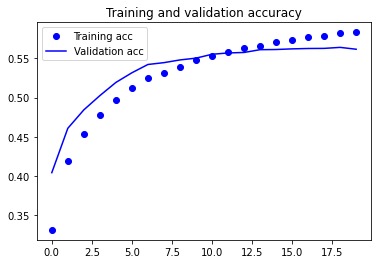

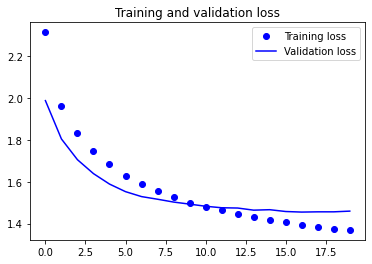

In [37]:
# Plot the Training and Validation Accuracy & Loss Scores
import matplotlib.pyplot as plt

%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Step 2 – Develop Character Generator Model (GRU Prevent Overfitting with Batch Normalization)

In [29]:
model = keras.models.Sequential()
model.add(layers.GRU(128, return_sequences=True,input_shape=(maxlen, len(chars))))
model.add(layers.Dropout(0.3))
model.add(layers.GRU(128, return_sequences=True))
model.add(layers.Dropout(0.3))
model.add(layers.GRU(128))
model.add(layers.BatchNormalization())
model.add(layers.Dense(len(chars), activation='softmax'))
optimizer = optimizers.RMSprop(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['acc'])
model.summary()


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, 60, 128)           64896     
_________________________________________________________________
dropout_12 (Dropout)         (None, 60, 128)           0         
_________________________________________________________________
gru_5 (GRU)                  (None, 60, 128)           99072     
_________________________________________________________________
dropout_13 (Dropout)         (None, 60, 128)           0         
_________________________________________________________________
gru_6 (GRU)                  (None, 128)               99072     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense_7 (Dense)              (None, 39)               

In [30]:
history = model.fit(x, y,
                    epochs=20,
                    batch_size=128,
                    validation_split=0.2)


Train on 148516 samples, validate on 37130 samples
Epoch 1/20
148516/148516 [==============================] - 49s 328us/sample - loss: 2.3222 - acc: 0.3296 - val_loss: 2.2210 - val_acc: 0.3570s: 2.4192 - - ETA: 10s - loss: 2.3772 - a - ETA: 10s - loss: 2.3756 - acc: 0.31 - ETA: 10s - loss: 2.3754 - acc: 0.31 - ETA: 10s - loss:  - ETA: 8s - lo - ETA: 6s - loss: 2.3550 - acc: 0 - ETA: 6s - loss: 2.3534 - - ETA: 5s - loss: 2.3486 - acc - ETA: 4s - loss: 2.3455 - acc: 0.3 - ETA: 4s - - ETA: 2s - loss: 2.3332 - acc: 0 - ETA: 2s - loss: 2.33 - ETA: 0s - loss: 2.3257 - acc: 0.329 - ETA: 0s - loss: 2.3250 - acc: 0.3 - ETA: 0s - loss: 2.3241 - acc:
Epoch 2/20
148516/148516 [==============================] - 41s 275us/sample - loss: 2.0244 - acc: 0.3957 - val_loss: 1.9004 - val_acc: 0.4241 ETA: 8 - ETA: 2s -  - ETA: 0s - loss: 2.0245 - acc:
Epoch 3/20
148516/148516 [==============================] - 41s 277us/sample - loss: 1.8799 - acc: 0.4359 - val_loss: 1.7681 - val_acc: 0.4659 loss - ETA: 2

148516/148516 [==============================] - 40s 271us/sample - loss: 1.4009 - acc: 0.5692 - val_loss: 1.4537 - val_acc: 0.5633c - ETA: 31 - ETA:  - ETA: 24s - loss: 1.3890 - acc:  - ETA: 24s - loss: 1.38 - ETA: 23s - loss: 1.3872 - acc - ETA: 2 - ETA: 9s - loss: 1.3958 - acc: - ETA: 8s - loss: 1.3  - ETA: 5s - loss: 1.3971 - acc: 0.570 - ETA: 5s - loss: 1.3972 - acc: 0.57 - ETA: 5s - loss: 1.3977 - acc: 0.57 - ETA: 5s - loss: 1.3976 -  - ETA: 4s - loss: 1.3984 - ETA: 3s - loss: 1.3990 - - ETA: 2s - loss: 1.3992 - acc: - ETA: 2s - loss: 1.3989 - acc - ETA: 1s - loss: 1.398 - ETA: 0s - loss: 1.39
Epoch 20/20
148516/148516 [==============================] - 41s 274us/sample - loss: 1.3939 - acc: 0.5718 - val_loss: 1.4532 - val_acc: 0.5645905 - a - ETA - ETA: 16s  - ETA: 15s - loss: 1.3902 - acc - ETA: 15s -  - ETA: 14s - loss: 1.3916 - acc: 0.57 - ETA: 14 - ETA: 13s - loss: 1.3921 -  - ETA: - ETA: 6s - loss: 1.3924 -  - ETA: 6s - lo - ETA: 4s - loss: 1.3921 - acc: 0. - ETA: 4s - loss

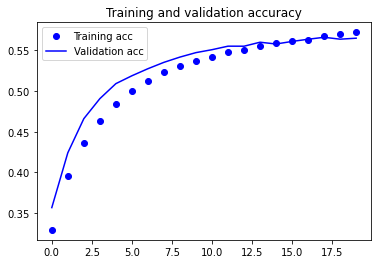

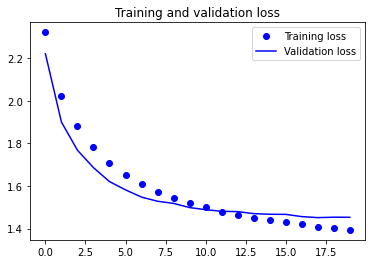

In [31]:
# Plot the Training and Validation Accuracy & Loss Scores
import matplotlib.pyplot as plt

%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Step 2 – Develop Character Generator Model (GRU Prevent Overfitting with Layer Normalization)

In [32]:
model = keras.models.Sequential()
model.add(layers.GRU(128, return_sequences=True,input_shape=(maxlen, len(chars))))
model.add(layers.Dropout(0.3))
model.add(layers.GRU(128, return_sequences=True))
model.add(layers.Dropout(0.3))
model.add(layers.GRU(128))
model.add(layers.LayerNormalization())
model.add(layers.Dense(len(chars), activation='softmax'))
optimizer = optimizers.RMSprop(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['acc'])
model.summary()


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_7 (GRU)                  (None, 60, 128)           64896     
_________________________________________________________________
dropout_14 (Dropout)         (None, 60, 128)           0         
_________________________________________________________________
gru_8 (GRU)                  (None, 60, 128)           99072     
_________________________________________________________________
dropout_15 (Dropout)         (None, 60, 128)           0         
_________________________________________________________________
gru_9 (GRU)                  (None, 128)               99072     
_________________________________________________________________
layer_normalization_2 (Layer (None, 128)               256       
_________________________________________________________________
dense_8 (Dense)              (None, 39)               

In [33]:
history = model.fit(x, y,
                    epochs=20,
                    batch_size=128,
                    validation_split=0.2)


Train on 148516 samples, validate on 37130 samples
Epoch 1/20
148516/148516 [==============================] - 48s 325us/sample - loss: 2.2746 - acc: 0.3353 - val_loss: 1.9942 - val_acc: 0.4044ETA: 44s - loss: 2.5726 - - ETA: 33s  - ETA: 31s - loss: 2. - ETA: 17s - loss: 2.3822 - acc - ETA: 17s - lo - ETA: 14s - loss: 2.3616 - acc - ETA - ETA: 10s - loss: 2.3382 - acc: 0. - ETA: 10s - loss: - ETA: 9s - los - ETA: 7s - loss:  - ETA: 5s - loss: 2.3107 - acc: 0.326 - ETA: 5s - ETA - ETA: 1s - loss: 2.2814 - ETA: 0s - loss: 2.2750 - acc: 0.335 - ETA: 0s - loss: 2.2747 - acc: 0.335
Epoch 2/20
148516/148516 [==============================] - 40s 272us/sample - loss: 1.9456 - acc: 0.4176 - val_loss: 1.8251 - val_acc: 0.4510 15s - loss: 1.9769 - - ETA: 15s -  - ETA: 13s - lo - ETA: 11s - loss: 1.9671 - acc: 0. - ETA: 11s  -  - ETA: 5s - loss: 1.9553 - ETA: 4s - loss: 1.9 - ETA: 3s - loss: 1 - ETA: 2s - loss: 1.9492 - a - ETA: 1s - loss: 1.9483 - - ETA: 1s - loss: 1.9478 - acc: 0.417 - ETA: 1s 

148516/148516 [==============================] - 41s 275us/sample - loss: 1.3743 - acc: 0.5752 - val_loss: 1.4532 - val_acc: 0.5642- ETA: 23s -  - ETA:  - ETA: 12s - loss - ETA: 10s - loss: 1.3677 - acc:  - ETA: 10s - loss: 1.3680 - acc - ETA: 10s - loss: 1. - ETA: 9s - loss: 1.367 - ETA: 8s - loss: 1.3696 - acc: 0.576 - ETA: 8s - loss: 1.3698 - acc: 0. - ETA: 7s - loss: 1.3690 - acc: 0.5 - ETA: 7s - loss: 1.3693 - acc: 0 - ETA: 7s - loss - ETA: 5s - loss: 1.3698 - acc:  - ETA: 2s - los - ETA: 1s - loss: 1.3736 - acc: 0.575 - ETA: 1s - loss: 1.3731 - acc: 0.575 - ETA: 1s - loss: 1.3734 - acc: - ETA: 0s - loss: 1.373
Epoch 20/20
148516/148516 [==============================] - 41s 276us/sample - loss: 1.3679 - acc: 0.5766 - val_loss: 1.4560 - val_acc: 0.56730 - acc:  - E - ETA: 5s - loss - ETA: 4s - loss: 1.3662 - ETA: 3s - loss: 1.3663 - acc: 0.577 - ETA: 3s - loss: 1.3660


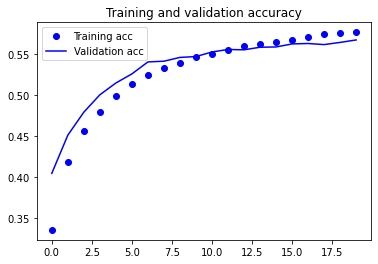

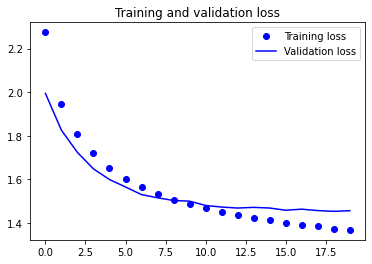

In [34]:
# Plot the Training and Validation Accuracy & Loss Scores
import matplotlib.pyplot as plt

%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Step 2 – Develop Character Generator Model (SimpleRNN Prevent Overfitting)

In [9]:
model = keras.models.Sequential()
model.add(layers.SimpleRNN(128, return_sequences=True,input_shape=(maxlen, len(chars))))
model.add(layers.Dropout(0.3))
model.add(layers.SimpleRNN(128, return_sequences=True))
model.add(layers.SimpleRNN(128, return_sequences=True))
model.add(layers.SimpleRNN(128))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(len(chars), activation='softmax'))
optimizer = optimizers.RMSprop(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['acc'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 60, 128)           21504     
_________________________________________________________________
dropout (Dropout)            (None, 60, 128)           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 60, 128)           32896     
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 60, 128)           32896     
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 39)                5

In [10]:
history = model.fit(x, y,
                    epochs=20,
                    batch_size=128,
                    validation_split=0.2)


Train on 148516 samples, validate on 37130 samples
Epoch 1/20
148516/148516 [==============================] - 143s 965us/sample - loss: 2.4651 - acc: 0.2994 - val_loss: 2.0616 - val_acc: 0.3952
Epoch 2/20
148516/148516 [==============================] - 134s 903us/sample - loss: 2.0442 - acc: 0.4011 - val_loss: 1.9035 - val_acc: 0.4358
Epoch 3/20
148516/148516 [==============================] - 137s 919us/sample - loss: 1.9056 - acc: 0.4378 - val_loss: 1.7958 - val_acc: 0.4605
Epoch 4/20
148516/148516 [==============================] - 135s 907us/sample - loss: 1.8290 - acc: 0.4576 - val_loss: 1.7426 - val_acc: 0.4760
Epoch 5/20
148516/148516 [==============================] - 135s 907us/sample - loss: 1.7761 - acc: 0.4730 - val_loss: 1.6869 - val_acc: 0.4936
Epoch 6/20
148516/148516 [==============================] - 134s 904us/sample - loss: 1.7369 - acc: 0.4857 - val_loss: 1.6538 - val_acc: 0.5045
Epoch 7/20
148516/148516 [==============================] - 135s 909us/sample - loss:

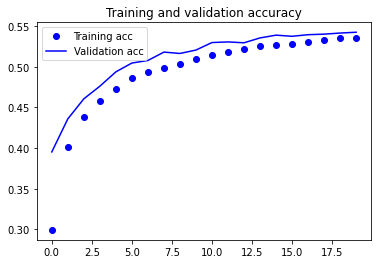

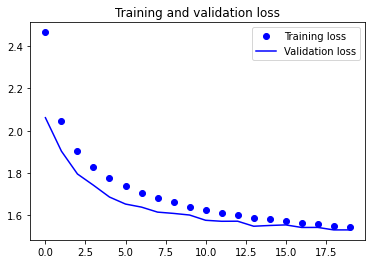

In [11]:
# Plot the Training and Validation Accuracy & Loss Scores
import matplotlib.pyplot as plt

%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Step 2 – Develop Character Generator Model (SimpleRNN Prevent Overfitting with Batch Normalization)

In [12]:
model = keras.models.Sequential()
model.add(layers.SimpleRNN(128, return_sequences=True,input_shape=(maxlen, len(chars))))
model.add(layers.SimpleRNN(128, return_sequences=True))
model.add(layers.SimpleRNN(128, return_sequences=True))
model.add(layers.SimpleRNN(128))
model.add(layers.Dropout(0.3))
model.add(layers.BatchNormalization())
model.add(layers.Dense(len(chars), activation='softmax'))
optimizer = optimizers.RMSprop(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['acc'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 60, 128)           21504     
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 60, 128)           32896     
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 60, 128)           32896     
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 39)               

In [13]:
history = model.fit(x, y,
                    epochs=20,
                    batch_size=128,
                    validation_split=0.2)


Train on 148516 samples, validate on 37130 samples
Epoch 1/20
148516/148516 [==============================] - 140s 945us/sample - loss: 2.6668 - acc: 0.2611 - val_loss: 2.1944 - val_acc: 0.3575
Epoch 2/20
148516/148516 [==============================] - 133s 895us/sample - loss: 2.0491 - acc: 0.4003 - val_loss: 1.9058 - val_acc: 0.4350
Epoch 3/20
148516/148516 [==============================] - 133s 899us/sample - loss: 1.8808 - acc: 0.4474 - val_loss: 1.7827 - val_acc: 0.4657
Epoch 4/20
148516/148516 [==============================] - 133s 895us/sample - loss: 1.7897 - acc: 0.4707 - val_loss: 1.7172 - val_acc: 0.4851
Epoch 5/20
148516/148516 [==============================] - 133s 898us/sample - loss: 1.7275 - acc: 0.4884 - val_loss: 1.6712 - val_acc: 0.4986
Epoch 6/20
148516/148516 [==============================] - 133s 897us/sample - loss: 1.6815 - acc: 0.5007 - val_loss: 1.6369 - val_acc: 0.5078
Epoch 7/20
148516/148516 [==============================] - 133s 895us/sample - loss:

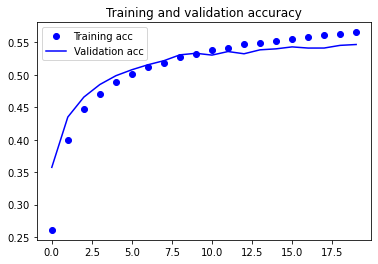

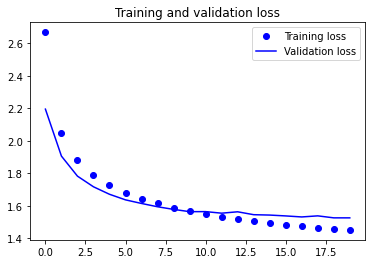

In [14]:
# Plot the Training and Validation Accuracy & Loss Scores
import matplotlib.pyplot as plt

%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Step 2 – Develop Character Generator Model (SimpleRNN Prevent Overfitting with Layer Normalization)

In [15]:
model = keras.models.Sequential()
model.add(layers.SimpleRNN(128, return_sequences=True,input_shape=(maxlen, len(chars))))
model.add(layers.SimpleRNN(128, return_sequences=True))
model.add(layers.SimpleRNN(128, return_sequences=True))
model.add(layers.SimpleRNN(128))
model.add(layers.Dropout(0.3))
model.add(layers.LayerNormalization())
model.add(layers.Dense(len(chars), activation='softmax'))
optimizer = optimizers.RMSprop(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['acc'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_8 (SimpleRNN)     (None, 60, 128)           21504     
_________________________________________________________________
simple_rnn_9 (SimpleRNN)     (None, 60, 128)           32896     
_________________________________________________________________
simple_rnn_10 (SimpleRNN)    (None, 60, 128)           32896     
_________________________________________________________________
simple_rnn_11 (SimpleRNN)    (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
layer_normalization (LayerNo (None, 128)               256       
_________________________________________________________________
dense_2 (Dense)              (None, 39)               

In [16]:
history = model.fit(x, y,
                    epochs=20,
                    batch_size=128,
                    validation_split=0.2)


Train on 148516 samples, validate on 37130 samples
Epoch 1/20
148516/148516 [==============================] - 141s 948us/sample - loss: 2.4358 - acc: 0.3080 - val_loss: 2.0723 - val_acc: 0.3900
Epoch 2/20
148516/148516 [==============================] - 135s 907us/sample - loss: 1.9853 - acc: 0.4173 - val_loss: 1.8698 - val_acc: 0.4496
Epoch 3/20
148516/148516 [==============================] - 135s 906us/sample - loss: 1.8454 - acc: 0.4565 - val_loss: 1.7796 - val_acc: 0.4776
Epoch 4/20
148516/148516 [==============================] - 134s 905us/sample - loss: 1.7616 - acc: 0.4798 - val_loss: 1.6986 - val_acc: 0.4972
Epoch 5/20
148516/148516 [==============================] - 134s 905us/sample - loss: 1.7033 - acc: 0.4961 - val_loss: 1.6683 - val_acc: 0.5081
Epoch 6/20
148516/148516 [==============================] - 135s 911us/sample - loss: 1.6582 - acc: 0.5066 - val_loss: 1.6366 - val_acc: 0.5163
Epoch 7/20
148516/148516 [==============================] - 135s 908us/sample - loss:

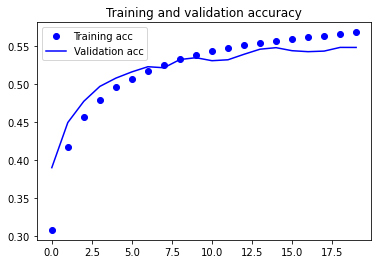

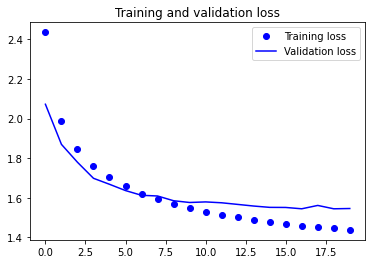

In [17]:
# Plot the Training and Validation Accuracy & Loss Scores
import matplotlib.pyplot as plt

%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Step 2 – Develop Character Generator Model (BiDirectionalLSTM + GRU Prevent Overfitting)

In [20]:
model = keras.models.Sequential()
model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True),input_shape=(maxlen, len(chars))))
model.add(layers.Dropout(0.3))
model.add(layers.GRU(128))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(len(chars), activation='softmax'))
optimizer = optimizers.RMSprop(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['acc'])
model.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 60, 256)           172032    
_________________________________________________________________
dropout_6 (Dropout)          (None, 60, 256)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               148224    
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 39)                5031      
Total params: 325,287
Trainable params: 325,287
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(x, y,
                    epochs=20,
                    batch_size=128,
                    validation_split=0.2)


Train on 148516 samples, validate on 37130 samples
Epoch 1/20
148516/148516 [==============================] - 51s 346us/sample - loss: 2.3620 - acc: 0.3172 - val_loss: 2.1196 - val_acc: 0.3715
Epoch 2/20
148516/148516 [==============================] - 43s 288us/sample - loss: 2.0728 - acc: 0.3848 - val_loss: 1.9535 - val_acc: 0.4176
Epoch 3/20
148516/148516 [==============================] - 43s 288us/sample - loss: 1.9439 - acc: 0.4217 - val_loss: 1.8243 - val_acc: 0.4487 - lo - ETA: 12 - ETA: 11s - loss: 1.957 - ETA: 8s - loss: 1.9560 -  - ETA: 8s - loss: 1.955 - ETA: 7 - ETA: 5 - ETA: 3s - loss: 1.9481 - acc:  - ETA: 2s - loss: 1.9478 -  - ETA: 1s - loss: 1.9471 - acc: - ETA: 1s - los
Epoch 4/20
148516/148516 [==============================] - 43s 291us/sample - loss: 1.8540 - acc: 0.4454 - val_loss: 1.7507 - val_acc: 0.4703
Epoch 5/20
148516/148516 [==============================] - 43s 292us/sample - loss: 1.7918 - acc: 0.4610 - val_loss: 1.6983 - val_acc: 0.487450 - acc: 0 - ET

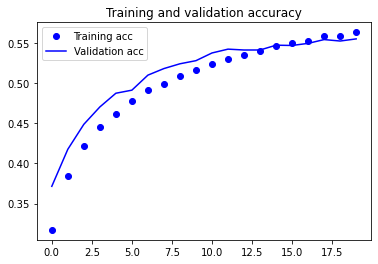

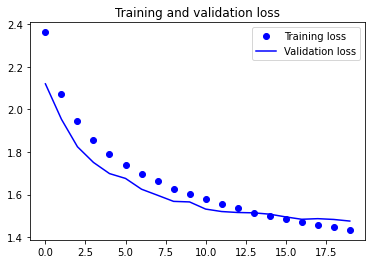

In [22]:
# Plot the Training and Validation Accuracy & Loss Scores
import matplotlib.pyplot as plt

%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Step 2 – Develop Character Generator Model (BiDirectionalLSTM + GRU Prevent Overfitting with Batch Normalization)

In [23]:
model = keras.models.Sequential()
model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True),input_shape=(maxlen, len(chars))))
model.add(layers.Dropout(0.3))
model.add(layers.GRU(128))
model.add(layers.Dropout(0.3))
model.add(layers.BatchNormalization())
model.add(layers.Dense(len(chars), activation='softmax'))
optimizer = optimizers.RMSprop(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['acc'])
model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 60, 256)           172032    
_________________________________________________________________
dropout_8 (Dropout)          (None, 60, 256)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               148224    
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_5 (Dense)              (None, 39)                5031      
Total params: 325,799
Trainable params: 325,543
Non-trainable params: 256
______________________________________________

In [24]:
history = model.fit(x, y,
                    epochs=20,
                    batch_size=128,
                    validation_split=0.2)


Train on 148516 samples, validate on 37130 samples
Epoch 1/20
148516/148516 [==============================] - 52s 347us/sample - loss: 2.3354 - acc: 0.3249 - val_loss: 2.0940 - val_acc: 0.37212.3709 - acc: 0. - ETA: 7s - loss: - ETA: 6s - loss: 2.3 - ETA: 4s - loss: 2.3556 - acc: 0.32 - ETA: 4s - loss: 2.3547  - ETA: 3s - loss: 2 - ETA: 1s - loss:  - ETA: 0s - loss: 2.3370 - acc: 0
Epoch 2/20
148516/148516 [==============================] - 45s 300us/sample - loss: 2.0639 - acc: 0.3864 - val_loss: 1.9095 - val_acc: 0.4269 10s - loss: 2.0782 - ac - - ETA: 1s - loss: 2.0664 - acc: - ETA: 1s - loss: 2.
Epoch 3/20
148516/148516 [==============================] - 46s 306us/sample - loss: 1.9290 - acc: 0.4246 - val_loss: 1.8129 - val_acc: 0.4531
Epoch 4/20
148516/148516 [==============================] - 47s 320us/sample - loss: 1.8394 - acc: 0.4503 - val_loss: 1.7451 - val_acc: 0.4743
Epoch 5/20
148516/148516 [==============================] - 46s 311us/sample - loss: 1.7707 - acc: 0.4696 

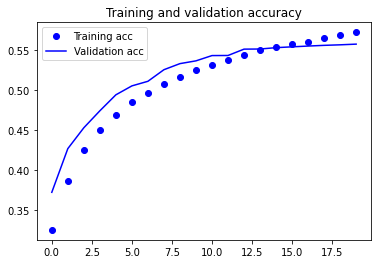

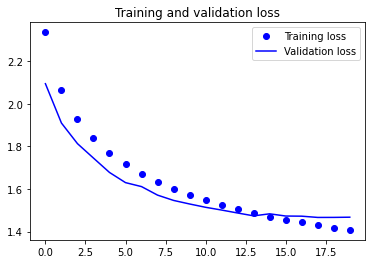

In [25]:
# Plot the Training and Validation Accuracy & Loss Scores
import matplotlib.pyplot as plt

%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Step 2 – Develop Character Generator Model (BiDirectionalLSTM + GRU Prevent Overfitting with Layer Normalization)

In [26]:
model = keras.models.Sequential()
model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True),input_shape=(maxlen, len(chars))))
model.add(layers.Dropout(0.3))
model.add(layers.GRU(128))
model.add(layers.Dropout(0.3))
model.add(layers.LayerNormalization())
model.add(layers.Dense(len(chars), activation='softmax'))
optimizer = optimizers.RMSprop(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['acc'])
model.summary()


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 60, 256)           172032    
_________________________________________________________________
dropout_10 (Dropout)         (None, 60, 256)           0         
_________________________________________________________________
gru_3 (GRU)                  (None, 128)               148224    
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
layer_normalization_1 (Layer (None, 128)               256       
_________________________________________________________________
dense_6 (Dense)              (None, 39)                5031      
Total params: 325,543
Trainable params: 325,543
Non-trainable params: 0
________________________________________________

In [27]:
history = model.fit(x, y,
                    epochs=20,
                    batch_size=128,
                    validation_split=0.2)


Train on 148516 samples, validate on 37130 samples
Epoch 1/20
148516/148516 [==============================] - 53s 357us/sample - loss: 2.3112 - acc: 0.3263 - val_loss: 2.0800 - val_acc: 0.37529 - acc: 0 - ETA: 0s - loss: 2.3126 - acc: 
Epoch 2/20
148516/148516 [==============================] - 46s 308us/sample - loss: 2.0431 - acc: 0.3916 - val_loss: 1.9092 - val_acc: 0.4275: 1s - loss: 2.0458 - acc - ETA: 1s - loss: 2.044
Epoch 3/20
148516/148516 [==============================] - 45s 304us/sample - loss: 1.9110 - acc: 0.4293 - val_loss: 1.7997 - val_acc: 0.4570 - a - ETA: 7s - loss: 1.9152 - ETA: 6s - l - ETA: 4s - loss: 1.9135 - ac - ETA: 4s - loss: 1.9125 - - ETA: 3s - loss: 1.9116 - ETA
Epoch 4/20
148516/148516 [==============================] - 45s 302us/sample - loss: 1.8205 - acc: 0.4542 - val_loss: 1.7239 - val_acc: 0.4804  - ETA: 4s - loss: 1.8234  - ETA - ETA: 0s - loss: 1.8215 -
Epoch 5/20
148516/148516 [==============================] - 45s 301us/sample - loss: 1.7549 - 

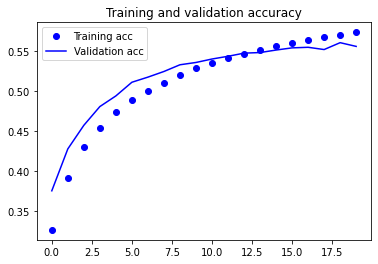

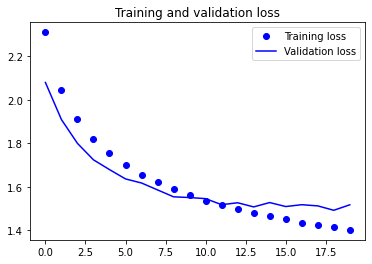

In [28]:
# Plot the Training and Validation Accuracy & Loss Scores
import matplotlib.pyplot as plt

%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Step 3 – Use the developed Model to generate the characters / sentences

In [10]:
# WORD ERROR RATE CODE: Taken from https://github.com/zszyellow/WER-in-python/blob/master/wer.py
import sys
import numpy

def editDistance(r, h):
    '''
    This function is to calculate the edit distance of reference sentence and the hypothesis sentence.
    Main algorithm used is dynamic programming.
    Attributes: 
        r -> the list of words produced by splitting reference sentence.
        h -> the list of words produced by splitting hypothesis sentence.
    '''
    d = numpy.zeros((len(r)+1)*(len(h)+1), dtype=numpy.uint8).reshape((len(r)+1, len(h)+1))
    for i in range(len(r)+1):
        d[i][0] = i
    for j in range(len(h)+1):
        d[0][j] = j
    for i in range(1, len(r)+1):
        for j in range(1, len(h)+1):
            if r[i-1] == h[j-1]:
                d[i][j] = d[i-1][j-1]
            else:
                substitute = d[i-1][j-1] + 1
                insert = d[i][j-1] + 1
                delete = d[i-1][j] + 1
                d[i][j] = min(substitute, insert, delete)
    return d

def getStepList(r, h, d):
    '''
    This function is to get the list of steps in the process of dynamic programming.
    Attributes: 
        r -> the list of words produced by splitting reference sentence.
        h -> the list of words produced by splitting hypothesis sentence.
        d -> the matrix built when calulating the editting distance of h and r.
    '''
    x = len(r)
    y = len(h)
    list = []
    while True:
        if x == 0 and y == 0: 
            break
        elif x >= 1 and y >= 1 and d[x][y] == d[x-1][y-1] and r[x-1] == h[y-1]: 
            list.append("e")
            x = x - 1
            y = y - 1
        elif y >= 1 and d[x][y] == d[x][y-1]+1:
            list.append("i")
            x = x
            y = y - 1
        elif x >= 1 and y >= 1 and d[x][y] == d[x-1][y-1]+1:
            list.append("s")
            x = x - 1
            y = y - 1
        else:
            list.append("d")
            x = x - 1
            y = y
    return list[::-1]

def alignedPrint(list, r, h, result):
    '''
    This funcition is to print the result of comparing reference and hypothesis sentences in an aligned way.
    
    Attributes:
        list   -> the list of steps.
        r      -> the list of words produced by splitting reference sentence.
        h      -> the list of words produced by splitting hypothesis sentence.
        result -> the rate calculated based on edit distance.
    '''
    print("REF:", end=" ")
    for i in range(len(list)):
        if list[i] == "i":
            count = 0
            for j in range(i):
                if list[j] == "d":
                    count += 1
            index = i - count
            print(" "*(len(h[index])), end=" ")
        elif list[i] == "s":
            count1 = 0
            for j in range(i):
                if list[j] == "i":
                    count1 += 1
            index1 = i - count1
            count2 = 0
            for j in range(i):
                if list[j] == "d":
                    count2 += 1
            index2 = i - count2
            if len(r[index1]) < len(h[index2]):
                print(r[index1] + " " * (len(h[index2])-len(r[index1])), end=" ")
            else:
                print(r[index1], end=" "),
        else:
            count = 0
            for j in range(i):
                if list[j] == "i":
                    count += 1
            index = i - count
            print(r[index], end=" "),
    print("\nHYP:", end=" ")
    for i in range(len(list)):
        if list[i] == "d":
            count = 0
            for j in range(i):
                if list[j] == "i":
                    count += 1
            index = i - count
            print(" " * (len(r[index])), end=" ")
        elif list[i] == "s":
            count1 = 0
            for j in range(i):
                if list[j] == "i":
                    count1 += 1
            index1 = i - count1
            count2 = 0
            for j in range(i):
                if list[j] == "d":
                    count2 += 1
            index2 = i - count2
            if len(r[index1]) > len(h[index2]):
                print(h[index2] + " " * (len(r[index1])-len(h[index2])), end=" ")
            else:
                print(h[index2], end=" ")
        else:
            count = 0
            for j in range(i):
                if list[j] == "d":
                    count += 1
            index = i - count
            print(h[index], end=" ")
    print("\nEVA:", end=" ")
    for i in range(len(list)):
        if list[i] == "d":
            count = 0
            for j in range(i):
                if list[j] == "i":
                    count += 1
            index = i - count
            print("D" + " " * (len(r[index])-1), end=" ")
        elif list[i] == "i":
            count = 0
            for j in range(i):
                if list[j] == "d":
                    count += 1
            index = i - count
            print("I" + " " * (len(h[index])-1), end=" ")
        elif list[i] == "s":
            count1 = 0
            for j in range(i):
                if list[j] == "i":
                    count1 += 1
            index1 = i - count1
            count2 = 0
            for j in range(i):
                if list[j] == "d":
                    count2 += 1
            index2 = i - count2
            if len(r[index1]) > len(h[index2]):
                print("S" + " " * (len(r[index1])-1), end=" ")
            else:
                print("S" + " " * (len(h[index2])-1), end=" ")
        else:
            count = 0
            for j in range(i):
                if list[j] == "i":
                    count += 1
            index = i - count
            print(" " * (len(r[index])), end=" ")
    print("\nWER: " + result)
def shortprint(result):
    print("\nWER: " + result)
def wer(r, h):
    """
    This is a function that calculate the word error rate in ASR.
    You can use it like this: wer("what is it".split(), "what is".split()) 
    """
    # build the matrix
    d = editDistance(r, h)

    # find out the manipulation steps
    list = getStepList(r, h, d)

    # print the result in aligned way
    result = float(d[len(r)][len(h)]) / len(r) * 100
    result = str("%.2f" % result) + "%"
    #alignedPrint(list, r, h, result)
    shortprint(result)


## Best LSTM model

In [53]:
model =models.load_model('D://NPY2SEM1//DL//Asg2//CompiledFinalModels//LSTM-Layer-Final.h5')
model.load_weights('D://NPY2SEM1//DL//Asg2//CompiledFinalModels//LSTM-Layer-Final.h5')

In [54]:
# Use the Best Model to generate 400 characters
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature # take a log function and then divided by temperature
    exp_preds = np.exp(preds) # take a exp function
    preds = exp_preds / np.sum(exp_preds) # normalize to 1
    probas = np.random.multinomial(1, preds, 1) # roll a dice based on the probability distribution in preds
    return np.argmax(probas)

start_index = random.randint(0, len(clean_text) - maxlen - 1)
generated_text_initial = clean_text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text_initial + '"')

for temperature in [0.2, 0.5, 1.0, 1.2]:
    generated_text = generated_text_initial
    WER_tempwords = generated_text_initial
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

    # We generate 400 characters
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = model.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]
        WER_tempwords += next_char

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()
    wer(clean_text[start_index: start_index + maxlen +400],WER_tempwords)

--- Generating with seed: " seized my hair in both his hands, and tugged until i yelled"
------ temperature: 0.2
 seized my hair in both his hands, and tugged until i yelled the case of the companion of the country of the companion.  i have already a country of the companion of the side of the country of the present of the country of the country of the companion of the country of the consider of the companion of the country of the country of the country of the country of the companion of the country of the consider of the papers of the companion of the lady.  it was 

WER: 10.22%
------ temperature: 0.5
 seized my hair in both his hands, and tugged until i yelled out of the companion of the corner, and a little deed and left the case of the considerably stone, but i cannot that it was some left the plance of the country, and then a man which i heard the truess of the companion which he had readly feething and led that it must be a singular pance of the consider which were then he had b

# Best SimpleRNN

In [55]:
model = models.load_model('D://NPY2SEM1//DL//Asg2//CompiledFinalModels//SimpleRNN-Layer-Final.h5')
model.load_weights('D://NPY2SEM1//DL//Asg2//CompiledFinalModels//SimpleRNN-Layer-Final.h5')

In [56]:
# Use the Best Model to generate 400 characters
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature # take a log function and then divided by temperature
    exp_preds = np.exp(preds) # take a exp function
    preds = exp_preds / np.sum(exp_preds) # normalize to 1
    probas = np.random.multinomial(1, preds, 1) # roll a dice based on the probability distribution in preds
    return np.argmax(probas)

start_index = random.randint(0, len(clean_text) - maxlen - 1)
generated_text_initial = clean_text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text_initial + '"')

for temperature in [0.2, 0.5, 1.0, 1.2]:
    generated_text = generated_text_initial
    WER_tempwords = generated_text_initial
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

    # We generate 400 characters
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = model.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]
        WER_tempwords += next_char

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()
    wer(clean_text[start_index: start_index + maxlen +400],WER_tempwords)

--- Generating with seed: "ir, with the thick blue cloud-wreaths spinning up from him, "
------ temperature: 0.2
ir, with the thick blue cloud-wreaths spinning up from him, and the whole been the papers and the detort, and i have been the singular to the papers and little back and the lady way the country with the singular possible that i have been a cound, and the counted and her with the cound that i have been a cound, and the cound that i have been a cound that i have been a cound, and the street of the street which i was a breaks and the lady and cound that i can

WER: 10.43%
------ temperature: 0.5
ir, with the thick blue cloud-wreaths spinning up from him, when i delemp of my startions of the londer watson, and the matter, but i have been with a ketter and have been little before you was a cound the cound.  how it was a cound that i have me that it is not evening of the lady, the stout of the busand on the porise to the disting in the thild her the contrily and could not looking 

## Best GRU Model 

In [57]:
model = models.load_model('D://NPY2SEM1//DL//Asg2//CompiledFinalModels//GRU-Layer-Final.h5')
model.load_weights('D://NPY2SEM1//DL//Asg2//CompiledFinalModels//GRU-Layer-Final.h5')

In [58]:
# Use the Best Model to generate 400 characters
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature # take a log function and then divided by temperature
    exp_preds = np.exp(preds) # take a exp function
    preds = exp_preds / np.sum(exp_preds) # normalize to 1
    probas = np.random.multinomial(1, preds, 1) # roll a dice based on the probability distribution in preds
    return np.argmax(probas)

start_index = random.randint(0, len(clean_text) - maxlen - 1)
generated_text_initial = clean_text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text_initial + '"')

for temperature in [0.2, 0.5, 1.0, 1.2]:
    generated_text = generated_text_initial
    WER_tempwords = generated_text_initial
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

    # We generate 400 characters
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = model.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]
        WER_tempwords += next_char

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()
    wer(clean_text[start_index: start_index + maxlen +400],WER_tempwords)

--- Generating with seed: "farm and the private park of the wealthy mr. turner. above t"
------ temperature: 0.2
farm and the private park of the wealthy mr. turner. above the state of the statement which i shall such a parce of the little could be some the other street and started and started and started of the state of the street.  i have no doubt that the lady is a strong the papers of the street.  what was a part of the street of the street.  what is i have not a suddenly strong the station.  i shall see the part of my steps which i have some stone the street.  i

WER: 8.04%
------ temperature: 0.5
farm and the private park of the wealthy mr. turner. above the inspector and at the point of the steps which may be the street of my own a death to the love, when the other which had been a suddenly passed and should see her the paper side of the station.  mr. holmes. i was a strong him a marriage to see that it was a step for seen a hand as i am a strong the man so all the stute of the 

# Best BiDirectional LSTM + GRU 

In [59]:
model = models.load_model('D://NPY2SEM1//DL//Asg2//CompiledFinalModels//BiDirectionLSTMGRU-Batch-Final.h5')
model.load_weights('D://NPY2SEM1//DL//Asg2//CompiledFinalModels//BiDirectionLSTMGRU-Batch-Final.h5')

In [60]:
# Use the Best Model to generate 400 characters
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature # take a log function and then divided by temperature
    exp_preds = np.exp(preds) # take a exp function
    preds = exp_preds / np.sum(exp_preds) # normalize to 1
    probas = np.random.multinomial(1, preds, 1) # roll a dice based on the probability distribution in preds
    return np.argmax(probas)

start_index = random.randint(0, len(clean_text) - maxlen - 1)
generated_text_initial = clean_text[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text_initial + '"')

for temperature in [0.2, 0.5, 1.0, 1.2]:
    generated_text = generated_text_initial
    WER_tempwords = generated_text_initial
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

    # We generate 400 characters
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = model.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]
        WER_tempwords += next_char

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()
    wer(clean_text[start_index: start_index + maxlen +400],WER_tempwords)

--- Generating with seed: ", glancing at the postmark.  'some preposterous practical jo"
------ temperature: 0.2
, glancing at the postmark.  'some preposterous practical john of the face of the face was a shadle between the man who had been a probable and had been and faced and the case of the bedrouse, and i have a follow a can which was a back and a should be a carriage and his hands and a father was a carriage which was a carriage and a strange and a fall and was a back and a father was a commons of a commons of the strange and the case of the considerable strang

WER: 13.04%
------ temperature: 0.5
, glancing at the postmark.  'some preposterous practical joones. and what was us. i shall be of the father. i have not it in the man who had been liven my bedrerable the man who had been every beant and which i can see him thin he had found my as was the could conferial of the precession of a great of morning.  having the door so that we had been a point of clear of course, i shall be 

# Real Life Text Input with Best Model 

In [50]:
model = models.load_model('D://NPY2SEM1//DL//Asg2//CompiledFinalModels//LSTM-Layer-Final.h5')
model.load_weights('D://NPY2SEM1//DL//Asg2//CompiledFinalModels//LSTM-Layer-Final.h5')

In [51]:
text_input = input()


one which has ever been considered as a mystery; yet with how many things are we upon the brink of becoming acquainted, if cowardice or carelessness did not restrain our inquiries. I revolved these circumstances in my mind and determined thenceforth to apply myself more particularly to those branches of natural philosophy which relate to physiology. Unless I had been animated by an almost supernatural enthusiasm, my application to this study would have been irksome and almost intolerable. To examine the causes of life, we must first have recourse to death. I became acquainted with the science of anatomy, but this was not sufficient; I must also observe the natural decay and corruption of the human body. In my education my father had taken the greatest precautions that my mind should be impressed with no supernatural horrors. I do not ever remember to have trembled at a tale of superstition or to have feared the apparition of a spirit. Darkness had no effect upon my fancy, and a churchy

In [52]:
start_index = 0
generated_text_initial = text_input[start_index: start_index + maxlen]
print('--- Generating with seed: "' + generated_text_initial + '"')

for temperature in [0.2, 0.5, 1.0, 1.2]:
    generated_text = generated_text_initial
    WER_tempwords = generated_text_initial
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)

    # We generate 400 characters
    for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.

        preds = model.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]
        WER_tempwords += next_char
        
        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()
    wer(text_input[start_index: start_index + maxlen +400],WER_tempwords)

--- Generating with seed: "one which has ever been considered as a mystery; yet with ho"
------ temperature: 0.2
one which has ever been considered as a mystery; yet with hormer of the companion.  i think that i have been one of the stood between the street.  i should have seen the companion of the consider of the companion of the country of the deep strange in the papers of the pain of the country of the stone which i have already at the companion of the lady and strange at the companion of the companion of the companion of the country of the country of the stone wh

WER: 13.70%
------ temperature: 0.5
one which has ever been considered as a mystery; yet with hormer was a man thought the dutter of my companion which i shall go down the street. then i was a little business and compled that the she out of the stone which were graved a started some of the case, and then he said the trues which had been forthed and one of the companion of the little and limp at the time of the complumman,